## SVMスクラッチ
分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。
SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。



### 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
λ
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import StandardScaler
import math

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = ["sepal_length" , "sepal_width" , "petal_length" , "petal_width"]
y.columns = ["Species"]
df = pd.concat([X , y] , axis = 1)
df_cn = df.query("Species == [1,2]").loc[: , :]
X_iris = df_cn.iloc[: , 2:4].values
y_iris = df_cn.iloc[: , -1].values
y_iris[y_iris==2] = -1
X = X_iris
y = y_iris

In [5]:
class ScratchSVMClassifier():
    """
    SVMのスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter=100, lr=0.00001, verbose=True,C=10**10 , kernel='rbf' , la = 0.0001):
        # ハイパーパラメータを属性として記録
        self.lamda = None
        self.ka = None
        
        self.iter = num_iter
        self.lr = lr
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.C = C
        self.kernel = kernel #線形カーネル
        self.la = la
        self.y = y
        
        
    def kernel_(self , X ):
        return np.dot(X , X.T)
    
#     def kernel_2(self , X , Xn , k = 1):
#         return k * np.dot(X , self.Xn.T)
    
    def _gradient_descent(self , X , y):
        sum_xy = self.ka_y * self.ka_X
        rag = np.sum(np.dot(self.lamda , sum_xy.T))
        self.lamda = self.lamda + self.lr *(1 - rag)
        return self.lamda

    def fit(self, X, y, X_val=None, y_val=None):
        """
         SVMを学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        np.random.seed(0)
        self.lamda = np.random.rand(X.shape[0])*0.01
        
        for i in range(self.iter):
            self.ka_X = self.kernel_(X )
            self.ka_y = self.kernel_(y)
            self.lam = self._gradient_descent(X , y)
            
        index_ = []
        for i , d in enumerate(self.lamda):
            if d > self.la:
                index_.append(i)
        self.lamda[self.lamda < 0] = 0
        self.Xn = X[index_]
        self.yn = y[index_].reshape(1,-1)
        self.lamda = self.lamda[index_].reshape(-1,1)
#         sum_xyn = self.yn * (np.dot(X , self.Xn.T))
#         self.y_pred = np.sum((self.lamda_n * sum_xyn.T) , axis = 1)

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.lamda.shape)


    def predict(self, X):
        """
        SVMを使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVMによる推定結果
        """
        sum_xn =np.dot(X , self.Xn.T)
        sum_xyn =  self.yn * sum_xn
        self.y_pred = np.sum((self.lamda * sum_xyn.T) , axis = 0)
        for i in range(self.y_pred.shape[0]):
            if self.y_pred[i] < 0:
                self.y_pred[i] = -1
            else:
                self.y_pred[i] =  1
#         np.where(self.y_pred < 0 , -1,1)
#         sum_xyn = self.yn * (np.dot(X , self.Xn.T))
#         y_pred = np.sum(np.dot(self.lamda_n , sum_xyn.T))
        return self.y_pred


In [6]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(
               X_iris , y_iris , test_size = 0.25)

In [7]:
svm = ScratchSVMClassifier()
svm.fit(X_train , y_train)

(75, 1)


In [8]:
svm.predict(X_test)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [9]:
from sklearn.svm import SVC
sv = SVC()
sv.fit(X_train , y_train)
sv.predict(X_test)

array([-1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1,
        1,  1, -1, -1,  1,  1, -1, -1])

### 【問題2】サポートベクターの決定
計算したラグランジュ乗数 
λ
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

### 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
f
(
x
)
 の符号が分類結果です。
 $$
 f(x) = \sum_{n=1}^{N}\lambda_n y_{sv\_n} k(x, s_n)
$$
x
 : 推定したいデータの特徴量ベクトル


N
 : サポートベクターの数


n
 : サポートベクターのインデックス


λ
n
 : 
n
番目のサポートベクターのラグランジュ乗数


y
s
v
n
 : 
n
番目のサポートベクターのラベル


k
(
)
 : カーネル関数


s
n
 : 
n
番目のサポートベクターの特徴量

## 検証
### 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください

In [10]:
from sklearn.metrics import accuracy_score , precision_score , recall_score, f1_score ,  confusion_matrix


In [11]:
def learn_model(X , y , model = svm):
    X_train , X_test , y_train , y_test = train_test_split(
                  X , y , test_size = 0.25)
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test)  
    score = accuracy_score(y_test , y_pred)
    pre_score = precision_score(y_test , y_pred)
    re_score = recall_score(y_test , y_pred)
    f_score = f1_score(y_test , y_pred)
    con_mat = confusion_matrix(y_test , y_pred)
    
    print("accuracy_score :" , score)
    print("precision_score :" , pre_score)
    print("recall_score :" , re_score)
    print("f1_score :" , f_score)
    print("confusion_matrix :" , con_mat)

シンプルデータセット1

In [12]:
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X_2 = X[random_index]
y_2 = y[random_index]

In [13]:
learn_model(X_2 , y_2)

(375, 1)
accuracy_score : 1.0
precision_score : 1.0
recall_score : 1.0
f1_score : 1.0
confusion_matrix : [[62  0]
 [ 0 63]]


シンプルデータセット2

In [14]:
X_3 = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y_3 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
y_3[y_3==0]=-1

In [15]:
learn_model(X_3 , y_3)

(20, 1)
accuracy_score : 0.3
precision_score : 0.5
recall_score : 0.2857142857142857
f1_score : 0.36363636363636365
confusion_matrix : [[1 2]
 [5 2]]


### 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    marker = ["o" , "^"]

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker=marker[i])
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.scatter(svm.Xn[: , 0], svm.Xn[:,1] , color = "white")
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

シンプルデータセット1

In [17]:
X_train , X_test , y_train , y_test = train_test_split(
                  X_2 , y_2 , test_size = 0.25)

In [18]:
svm = ScratchSVMClassifier(lr = 1e-11, num_iter = 150000 , la = 0.005)
svm.fit(X_train , y_train)

(20, 1)


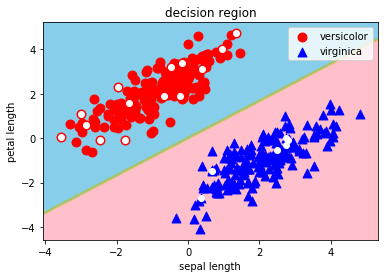

In [19]:
decision_region(X_train , y_train , svm ,  title='decision region', xlabel='sepal length', 
                             ylabel='petal length') #, target_names=['versicolor', 'virginica']

シンプルデータセット2

In [20]:
X_train , X_test , y_train , y_test = train_test_split(
                  X_3 , y_3 , test_size = 0.25)
svm = ScratchSVMClassifier(lr = 1e-11, num_iter = 150000 , la = 0.005)
svm.fit(X_train , y_train)

(14, 1)


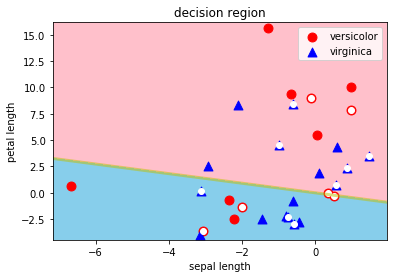

In [21]:
decision_region(X_train , y_train , svm ,  title='decision region', xlabel='sepal length', 
                             ylabel='petal length') #, target_names=['versicolor', 'virginica']